In [39]:
import matplotlib
from astropy import units as u
import aplpy
import numpy as np
import astropy.io.fits as fits
from astropy.io import ascii
from astropy.table import Column, Table
import os
%matplotlib inline

## 2 steps

In [42]:
def make_box(
             n_row,
             n_column,
             ra0,
             dec0,
             r,
             ):
    """
        Purpose:
        Making a box to cover the target source
        
        Input:
        n_row        [int]: The number of rows
        n_column     [int]: The number of columns
        ra0          [float]: RA for the first observing point (in degree)
        dec0         [float]: Dec for the first observing point (in degree)
        r            [float]: radius of the observing point
        
        return:
        ra        [float array]: 1d array for RA of each points (in the box)
        dec       [float array]: 1d array for Dec of each points (in the box)
    """
    
    n = n_row * n_column
    ra = np.zeros(n)
    for i in range(0,n):
        z = int(i/n_row) #####row number######
        if (z % 2 ==0):
            ra0 = ra0 - r * 2 
            ra[i] = ra0
        else:
            ra0 = ra0 + r * 2 
            ra[i] = ra0
        
   
    dec=np.zeros(n)
    for i in range(0,n):
        dec[i] = (float(dec0+int(i/n_row)*np.sqrt(3)*r))
    
    return ra, dec

def contour_select(
             n_row,
             n_column,
             ra,
             dec,
             fits_file,
             threshold,
             ):
    """
        Purpose:
        Selecting the points in the box based on flux or other parameters
        
        Input:
        n_row        [int]: The number of rows
        n_column     [int]: The number of columns
        ra           [float array]: 1d array for RA of each points (in the box)
        dec          [float array]: 1d array for Dec of each points (in the box)
        fits_file    [string]: filename of the input FITS image
        threshold    [float]: threshold of the contour
        
        return:
        ra_sec        [float array]: 1d array for RA of each points (in the contour)
        dec_sec       [float array]: 1d array for Dec of each points (in the contour)
    """
    
    # Read input image
    hdu = fits.open(fits_file)
    head = hdu[0].header
    data = hdu[0].data
    xrefpix = head['crpix1']
    xrefval = head['crval1']
    xwid = head['cdelt1']
    yrefpix = head['crpix2']
    yrefval = head['crval2']
    ywid = head['cdelt2']
    
    n = n_row * n_column
    xpix = np.ones_like(ra)
    ypix = np.ones_like(dec)
    for i in range(0,n):
        xpix[i] = (ra[i] - xrefval)/xwid + xrefpix -1
        ypix[i] = (dec[i] - yrefval)/ywid + yrefpix -1

    ra_sec = []
    dec_sec = []


    #######select the observing region based on flux (if need)
    for i in range(0,xpix.shape[0]):
        if data[int(ypix[i])][int(xpix[i])] > threshold :
            ra_sec.append(float(ra[i]))
            dec_sec.append(float(dec[i]))
    
    return ra_sec, dec_sec

## MOSAIC-Main

In [46]:
def mosaic(
             n_row,
             n_column,
             ra0,
             dec0,
             r,
             fits_file,
             threshold,
             csv_output,
             ):
    """
        Purpose:
        Getting the location of each observing point roughly in one loop 
        
        Input:
        n_row        [int]: The number of rows
        n_column     [int]: The number of columns
        ra0          [float]: RA for the first observing point (in degree)
        dec0         [float]: Dec for the first observing point (in degree)
        r            [float]: radius of the observing point (in degree)
        fits_file    [string]: filename of the input FITS image
        threshold    [float]: threshold of the contour
        csv_output   [string]: output filename
        
        return:
        ra_sec        [float array]: 1d array for RA of each points (in the contour)
        dec_sec       [float array]: 1d array for Dec of each points (in the contour)
        """
    
    ra, dec = make_box(n_row, n_column, ra0, dec0, r)
    ra_sec, dec_sec = contour_select(n_row, n_column, ra, dec, fits_file, threshold,)
    table=Table([ra_sec,dec_sec])
    
    outpath = csv_output
    if os.path.exists(outpath):
        os.remove(outpath)
    table.write(outpath,format='csv',overwrite=True)

    
    return ra_sec, dec_sec

# Test

The red point show the given reference loaction

INFO: Auto-setting vmin to  2.095e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.250e+01 [aplpy.core]


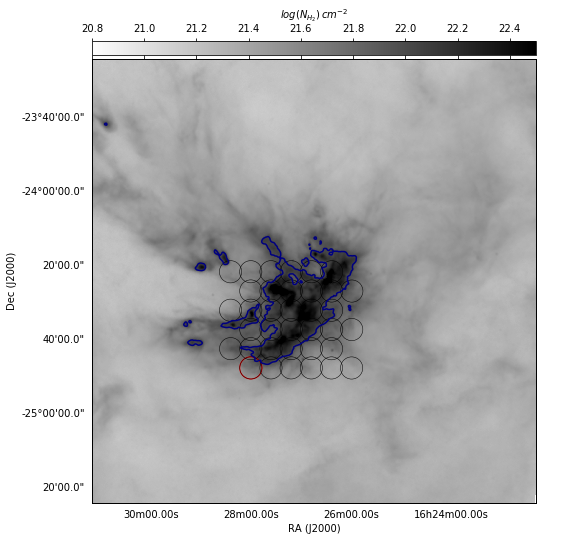

In [34]:
##########test box making##########

n_row_test = 6
n_column_test = 6
ra0_test = 247.1
dec0_test = -24.8
r_test = 0.05
ra, dec = make_box(n_row_test, n_column_test, ra0_test, dec0_test, r_test)



fig = aplpy.FITSFigure('/Users/shjiao/desktop/HGBS/oph_conv_erosion_try.fits',figsize=(8.5,8.5))
fig.show_grayscale()
fig.add_colorbar()
fig.colorbar.show()
fig.colorbar.set_axis_label_text(r'$log(N_{H_{2}})\, cm^{-2}$')

fig.colorbar.set_location('top')
fig.recenter(246.6879631142824,-24.40757996761378,width=2.,height=2.)
fig.show_colorscale(cmap='gist_yarg',vmin= 20.8,vmax=22.5)

fig.show_circles(float(ra[0]),float(dec[0]), 0.05,edgecolors='red',linewidths=1)

for i in range(0,ra.shape[0]):
    fig.show_circles(float(ra[i]),float(dec[i]), 0.05,edgecolors='black',linewidths=0.5)

fig.show_contour('/Users/shjiao/desktop/HGBS/oph_conv_erosion_try.fits', levels=[22.,], )



INFO: Auto-setting vmin to  2.095e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.250e+01 [aplpy.core]


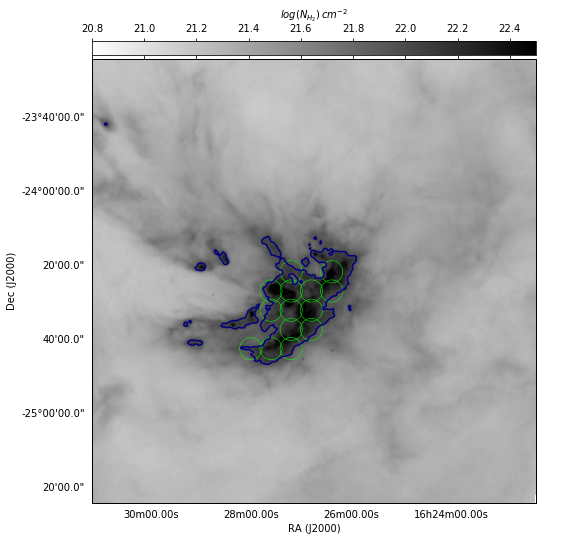

In [45]:
##########test mosaic##########

n_row_test = 6
n_column_test = 6
ra0_test = 247.1
dec0_test = -24.8
r_test = 0.05
fits_file = '/Users/shjiao/desktop/HGBS/oph_conv_erosion_try.fits'
threshold = 22.0
csv_output = '/Users/shjiao/desktop/test.csv'

ra_sec, dec_sec = mosaic(n_row_test, n_column_test, ra0_test, dec0_test, r_test, fits_file, threshold, csv_output)

fig = aplpy.FITSFigure('/Users/shjiao/desktop/HGBS/oph_conv_erosion_try.fits',figsize=(8.5,8.5))
fig.show_grayscale()
fig.add_colorbar()
fig.colorbar.show()
fig.colorbar.set_axis_label_text(r'$log(N_{H_{2}})\, cm^{-2}$')

fig.colorbar.set_location('top')
fig.recenter(246.6879631142824,-24.40757996761378,width=2.,height=2.)
fig.show_colorscale(cmap='gist_yarg',vmin= 20.8,vmax=22.5)

for i in range(0,len(ra_sec)):
    fig.show_circles(float(ra_sec[i]),float(dec_sec[i]), 0.05,edgecolors='lime',linewidths=0.5)

fig.show_contour('/Users/shjiao/desktop/HGBS/oph_conv_erosion_try.fits', levels=[22.,], )

